In [967]:
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [968]:
import os

data_path = "bike_sharing_dataset/"
files = os.listdir(data_path)
print(files)

['SeoulBikeData.csv']


In [969]:
df = pd.read_csv(data_path + "SeoulBikeData.csv", header=None)
print(df.head())

           0                  1     2               3            4   \
0        Date  Rented Bike Count  Hour  Temperature(C)  Humidity(%)   
1  01/12/2017                254     0            -5.2           37   
2  01/12/2017                204     1            -5.5           38   
3  01/12/2017                173     2              -6           39   
4  01/12/2017                107     3            -6.2           40   

                 5                 6                         7   \
0  Wind speed (m/s)  Visibility (10m)  Dew point temperature(C)   
1               2.2              2000                     -17.6   
2               0.8              2000                     -17.6   
3                 1              2000                     -17.7   
4               0.9              2000                     -17.6   

                        8             9              10       11           12  \
0  Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm)  Seasons  Holiday Day   
1       

In [970]:
df.columns = df.iloc[0]
df = df.drop(df.index[0])

In [971]:
df['Date'] = pd.to_datetime(df['Date'],format='%d/%m/%Y') 
df['Date']

1      2017-12-01
2      2017-12-01
3      2017-12-01
4      2017-12-01
5      2017-12-01
          ...    
8756   2018-11-30
8757   2018-11-30
8758   2018-11-30
8759   2018-11-30
8760   2018-11-30
Name: Date, Length: 8760, dtype: datetime64[ns]

In [972]:
df['Day']=df['Date'].dt.day
df['Month']=df['Date'].dt.month
df['Year']=df['Date'].dt.year
df.drop(columns=['Date'], inplace=True)

In [973]:
df['Seasons'] = df['Seasons'].replace({'Winter': 0, 'Autumn': 1, 'Spring': 2, 'Summer': 3})
df['Holiday Day'] = df['Holiday Day'].replace({'No Holiday': 0, 'Holiday': 1})

In [974]:
df = df[df['Functioning Day'] != 'No']
df.drop(columns=['Functioning Day'], inplace=True)

In [975]:
X = df.astype(float)

In [976]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["Variable"] = X.columns.values
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns.values))]
vif

,Variable,VIF
0,Rented Bike Count,4.771755
1,Hour,5.265818
2,Temperature(C),189.469374
3,Humidity(%),185.274681
4,Wind speed (m/s),4.909069
5,Visibility (10m),10.895715
6,Dew point temperature(C),127.120177
7,Solar Radiation (MJ/m2),2.928755
8,Rainfall(mm),1.129296
9,Snowfall (cm),1.160523


In [977]:
df.drop(columns=['Dew point temperature(C)',], inplace=True)

In [979]:
X = df.astype(float)
y = X.pop('Rented Bike Count')

# standardize the features
X -= X.mean()
X /= X.std()

In [980]:
X.columns.values

array(['Hour', 'Temperature(C)', 'Humidity(%)', 'Wind speed (m/s)',
       'Visibility (10m)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)',
       'Snowfall (cm)', 'Seasons', 'Holiday Day', 'Day', 'Month', 'Year'],
      dtype=object)

Trying to find distribution of values for estimated parameters

In [981]:
predictors = X.columns.values
coords = {"predictors": predictors}
with pm.Model(coords=coords) as model:
    # sd of the error term is 20 and sigma cannot be negative
    sigma = pm.HalfNormal('sigma', sigma=20) 
    alpha = pm.Normal('alpha', mu=0, sigma=20) 
    beta = pm.Normal('beta', mu=0, sigma=20, dims='predictors') # coefficients for each predictor
    
    # Expected value: lin comb of coeffs and predictors
    mu = pm.math.dot(beta, X.T) + alpha 
    
    # Likelihood (sampling distribution) of observations
    likelihood = pm.Normal('y', mu, sigma, observed=y)

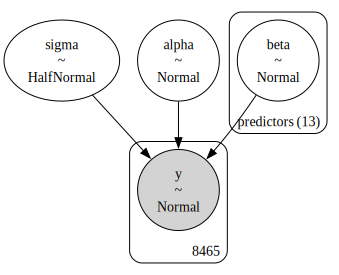

In [982]:
pm.model_to_graphviz(model)

In [983]:
with model:
    idata = pm.sample(1000, random_seed=42, progressbar=True, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.


In [984]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,690.95,4.61,682.69,699.94,0.06,0.04,6457.29,3162.44,1.0
beta[Hour],196.86,4.89,187.64,205.87,0.07,0.05,5266.18,3521.77,1.0
beta[Temperature(C)],268.59,8.72,253.30,286.34,0.17,0.12,2703.27,2837.93,1.0
beta[Humidity(%)],-142.30,6.91,-155.49,-129.71,0.11,0.08,3853.26,3588.66,1.0
beta[Wind speed (m/s)],15.36,5.25,5.75,25.29,0.07,0.05,6049.52,3561.35,1.0
beta[Visibility (10m)],11.27,5.69,0.34,21.82,0.08,0.06,5005.27,3437.89,1.0
beta[Solar Radiation (MJ/m2)],-40.39,5.93,-51.04,-29.13,0.10,0.07,3783.27,3251.02,1.0
beta[Rainfall(mm)],-70.03,4.79,-78.49,-60.67,0.06,0.04,6774.88,3137.63,1.0
beta[Snowfall (cm)],1.36,4.94,-7.67,10.88,0.06,0.07,6504.69,3357.17,1.0
beta[Seasons],47.67,7.86,32.95,62.05,0.14,0.10,3379.23,3023.06,1.0


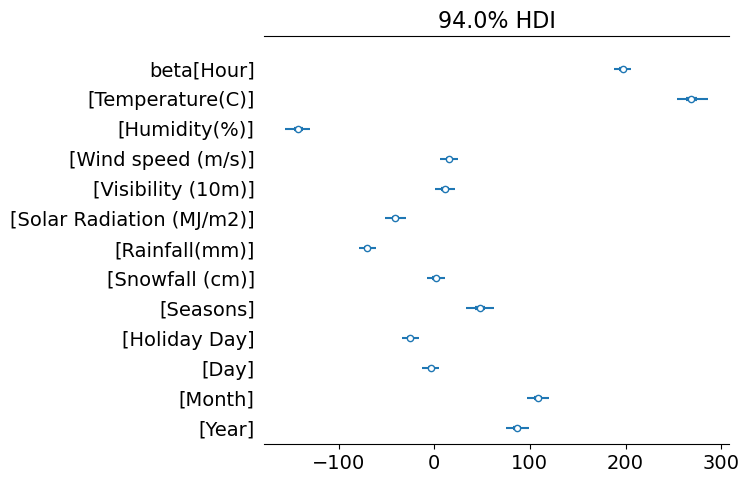

In [985]:
az.plot_forest(idata, var_names=['beta'], combined=True);